# Exploiting Correlation Between Model Accuracy and Explanation Quality

In this project, we have investigated the correlation between model accuracy and explanation quality on a new dataset. The project is based on this paper

*Studying and Exploiting the Relationship Between Model Accuracy and Explanation Quality;* By *Y. Jia, E. Frank, B. Pfahringer, A. Bifet, and N. Lim.*

We have written the code from scratch and build our own dataset. Our dataset contains 300 images, out of which 120 are positive images containing apples and 180 images are negative containing orther types of fruit other than apples. Also this dataset contains a directroy ``expl``, which contains positive images without background (only the part of the image which includs apple is kept). These kind of images are called expert explanations, by the authors of the paper, and are necessary for calculating the explanation quality.

The paper is about investigating the relationship between model accuracy and explanation quality, and how to use explanations to improve model performance. In this paper, they have evaluated explanations using a metric based on area under the ROC curve (AUC), treating expert-provided image annotations as ground-truth explanations, and quantify the correlation between model accuracy and explanation quality when performing image classifications with deep neural networks.

Furthermore, they studied how explanation quality evolves as loss metrics change through the training iterations of each model. The experiments suggest a strong correlation between model accuracy and explanation quality.

Since implementing this code needs GPU boosting computation, we have implemented it in google colab. However, even using google GPUs, it still takes several hours to complete.

**Important: We have added comments to the codes. We have explained some notes in these comments. Some of them contains important configurations for the code in order to get desirable results!**

In [ ]:
# If you want to use google colab, mount your google drive by the following code
from google.colab import drive  
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# By running this box, you will specify the base directory of the project.
base_dir = '/content/gdrive/'

# This will also install captum package, which is dedicated for different explanation methods.
!pip install captum

In [ ]:
# Importing neccessay library for this project
import sklearn
from sklearn import metrics
import sklearn.model_selection
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Subset
from torchvision import datasets, models, transforms
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import pandas as pd
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import GuidedBackprop
from captum.attr import GuidedGradCam
from captum.attr import Saliency
from captum.attr import visualization
from os import path
import copy

from IPython.display import display
#from google.colab import data_table
#from vega_datasets import data
#data_table.enable_dataframe_formatter()
#data.airports()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# If you use GPU, implement this box. If you use google colab, before this step, you also need to change
# the runtime to GPU, by going to Runtime > Change runtime type and setting "Hardware accelerator" tab to "GPU".
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Here we have defined image transformers used for importing the dataset:
transformer = transforms.Compose([
                                  transforms.Resize(224),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                  ])

transformer_without_normalizer = transforms.Compose([
                                                     transforms.Resize(256),
                                                     transforms.CenterCrop(224),
                                                     transforms.ToTensor()
                                                     ])

In [ ]:
# Importing datset
image_dataset = datasets.ImageFolder(base_dir+'/Dataset/data', transformer)

# Splitting dataset into 2 sets: one of them contains only test dataset and the other contains both validation and train dataset 
train_and_val_idx, test_idx = sklearn.model_selection.train_test_split(list(range(len(image_dataset))), test_size=.4, random_state=51)

# Splitting train and validation dataset
train_idx, val_idx = sklearn.model_selection.train_test_split(train_and_val_idx, train_size=7/9, random_state=20)

# We have set our batch size to 8. Since our dataset is small, we have set our batch size to 8, however larger batch size gives better results.
dataset_sep = {'train': Subset(image_dataset, train_idx), 'val': Subset(image_dataset, val_idx), 'test': Subset(image_dataset, test_idx)}
dataloader = {x: torch.utils.data.DataLoader(dataset_sep[x], batch_size = 16, shuffle = True, num_workers=0) for x in ['train', 'val', 'test']} 

In [ ]:
model_names = ['resnet18',
               'resnet50',
               'alexnet',
               'vgg',
               'squeezenet',
               #'densenet'
               ]

# Here we have not used the occlusion algothrim, because it takes a long time to compute the explanation qualities!
# however, you can uncomment it.
explainer_names = ['integratedGradient',
                   'gradientShap',
                   'saliency',
                   #'occlusion',
                   'guidedBackProp',
                   'guidedGradCAM'
                   ]


# This function intilises the model, we have used the pretrained models. Also, at the latest layer, we have set the number of
# classifiers to 2, simply becuase we only need to know whether an image is apple or not!

def initialize_model(model_name):
  if model_name == 'resnet18':
    model = models.resnet18(pretrained = True)
    model.fc = nn.Linear(model.fc.in_features, 2)

  elif model_name == 'resnet50':
    model = models.resnet50(pretrained = True)
    model.fc = nn.Linear(model.fc.in_features, 2)
  
  elif model_name == 'alexnet':
    model = models.alexnet(pretrained = True)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

  elif model_name == 'vgg':
    model = models.vgg11_bn(pretrained = True)
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)

  elif model_name == 'squeezenet':
    model = models.squeezenet1_0(pretrained = True)
    model.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1,1), stride=(1,1))

  else:
    model = models.densenet121(pretrained = True)
    model.classifier = nn.Linear(model.classifier.in_features, 2)

  return model

for model_name in model_names:
  initialize_model(model_name)

In [ ]:
# This function trains the models and returns back the trained model, the cross-entropy loss and the accuracy of the model
# which is defined to be the portion of the correct predictions over the whole train dataset.
# It is very important to note that the loss and the accuracy given by this function, are computed during the train process.
# we have used "stochastic gradient descent" in the back propogation step.
 
def train_model(model, dataloader):
  model.train()
  model.to(device)
  
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  
  criterion = nn.CrossEntropyLoss()
  
  running_loss = 0.0
  running_corrects = 0
  
  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    
    with torch.set_grad_enabled(True):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.detach().cpu().item() * inputs.size(0)      # This is on CPU
    running_corrects += torch.sum(preds == labels.data)              # This is on GPU

  model = model.eval()  
  loss = running_loss / len(dataloader.dataset)
  accuracy = running_corrects.detach().cpu().item() / len(dataloader.dataset)
  return model, loss, accuracy

In [ ]:
# This function returns back the loss and the accuracy of the model on the validation or test datasets.
# Again we have used cross-entropy loss and SGD in back propogation.

def evaluate_model(model, dataloader):
  model.eval()
  model.to(device)
  
  criterion = nn.CrossEntropyLoss()
  
  running_loss = 0.0
  running_corrects = 0
  
  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs, 1)
    running_loss += loss.detach().cpu().item() * inputs.size(0)      # This is on CPU
    running_corrects += torch.sum(preds == labels.data)              # This is on GPU

  loss = running_loss / len(dataloader.dataset)
  accuracy = running_corrects.detach().cpu().item() / len(dataloader.dataset)
  return loss, accuracy

In [ ]:
# If you wish to train a model, uncomment the following lines lines:
 
#test_model = initialize_model('alexnet')
#test_model, test_loss, test_accuracy = train_model(test_model, dataloader['train'])
#print(test_loss, test_accuracy)

In [ ]:
# If you wish to save the trained model from the previous box, uncomment these lines:

#torch.save(test_model.state_dict(), base_dir+'/test_model.pth')  # for saving model

In [ ]:
# For loading model afterwards, uncomment these lines:

#model = initialize_model(model_name)
#model.load_state_dict(torch.load(base_dir+'/test_model.pth', map_location=torch.device('cpu')))
#model.load_state_dict(torch.load(base_dir+'/test_model.pth'))

The next box will compute the attribution of an image. Basically, it is

**Definition:** Given an image input $x$ of size $(M,N)$ and a model $f$, the explanation (attribution) $e$ for the prediction $f(x)$ is a two dimensional array of the same size $(M,N)$, where each entry in $e$ is a real number and provides the attribution of the corresponding pixel in x.

**Definition:** Given an image input $x$ of size $(M,N)$ and a model $f$, an explainer is a procedure that takes $x$ and $f$ as inputs and returns an explanation $e$ for the prediction $f(x)$.

There are several explainers which we have used them in this code: *integratedGradient, gradientShap, saliency, occlusion, guidedBackProp, guidedGradCAM, ...*

In [ ]:
def attribution(model, model_name, explainer_name, img_path):
  model.eval()
  model.to(device)

  img = Image.open(img_path).convert('RGB')
  img = transformer(img)
  img = img.unsqueeze(0)
  img = img.to(device)
  output = model(img)
  _, pred = torch.max(output, 1)
  target = pred.item()

  if explainer_name == 'integratedGradient':
    explainer = IntegratedGradients(model)
    attr = explainer.attribute(img, target=target, n_steps=25)
    
  elif explainer_name == 'gradientShap':
    explainer = GradientShap(model)
    attr = explainer.attribute(img, n_samples=50, stdevs=0.0001, baselines=torch.cat([img*0, img*1]), target=target)

  elif explainer_name == 'saliency':
    explainer = Saliency(model)
    img.requires_grad = True
    attr = explainer.attribute(img, target)

  elif explainer_name == 'occlusion':
    explainer = Occlusion(model)
    attr = explainer.attribute(img, strides=(3,8,8), target=target, sliding_window_shapes=(3,15,15), baselines=0)
        
  elif explainer_name == 'guidedBackProp':
    explainer = GuidedBackprop(model)
    img.requires_grad = True
    attr = explainer.attribute(img, target)
    
  elif explainer_name == 'guidedGradCAM':
    if model_name == 'resnet18':
      layer = model.layer4
    elif model_name == 'resnet50':
      layer = model.layer4
    elif model_name == 'alexnet':
      layer = model.features[10]
    elif model_name == 'vgg':
      layer = model.features[25]
    elif model_name == 'squeezenet':
      layer = model.features[12]
    elif model_name == 'densenet':
      layer = model.features.denseblock4.denselayer16
    explainer = GuidedGradCam(model, layer)
    img.requires_grad = True
    attr = explainer.attribute(img, target)
  
  return attr

In the next box, we have visulasied the attribution of an image in our dataset by different explanation methods. The visulasations are in the heatmap format.

**If you wish to run the following box, you must have a trained model, and that you can easily obtain by uncommenting one of the above boxes which was dedicated for training a model.**

integratedGradient method applied to alexnet


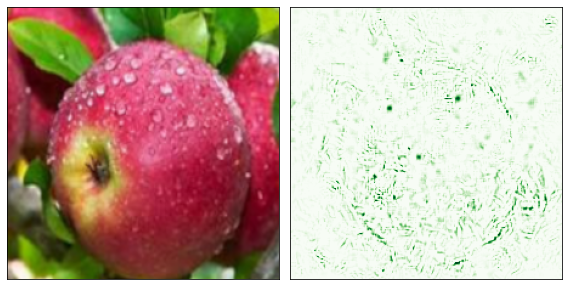





gradientShap method applied to alexnet


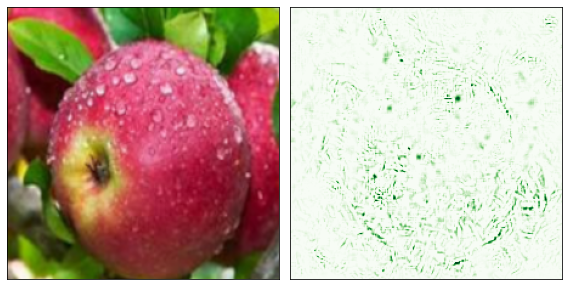





saliency method applied to alexnet


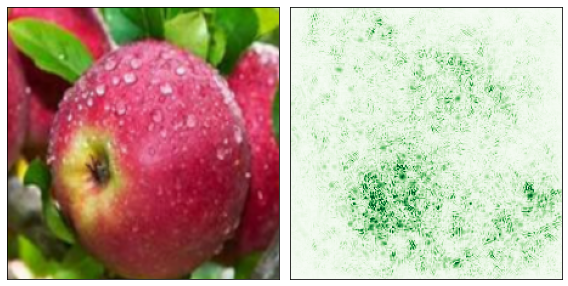





occlusion method applied to alexnet


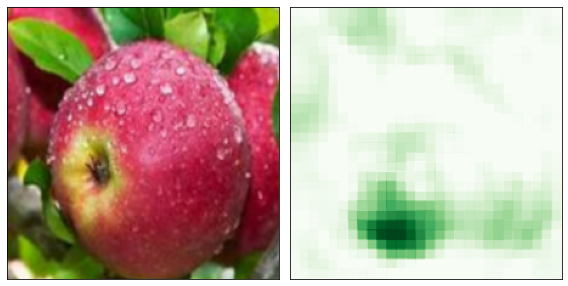





guidedBackProp method applied to alexnet


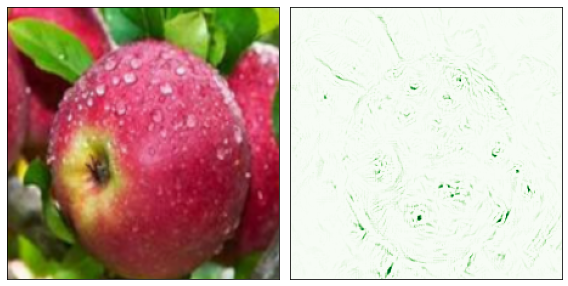





guidedGradCAM method applied to alexnet


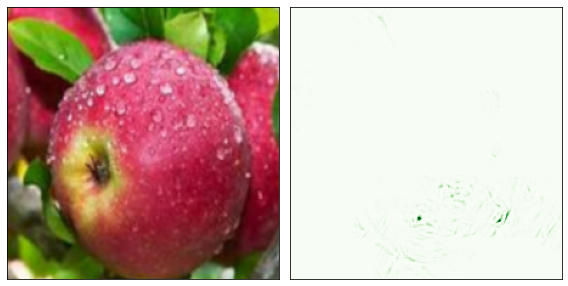

In [ ]:
#img_path = base_dir+"/Dataset/data/ve_positive/001.png"
#img = Image.open(img_path).convert('RGB')
#img = transformer_without_normalizer(img)

#model_name = 'alexnet'

#for explainer_name in explainer_names:
#  attr = attribution(test_model, model_name, explainer_name, img_path)
#  print(explainer_name + ' method applied to ' + model_name)
#  _ = visualization.visualize_image_attr_multiple(np.transpose(attr.squeeze().cpu().detach().numpy(), (1,2,0)),
#                                                  np.transpose(img.numpy(), (1,2,0)),
#                                                  ["original_image","heat_map"],
#                                                  ["all","positive"],
#                                                  show_colorbar=False,
#                                                  outlier_perc=2)
#  print('\n\n\n')

The following function calculates the explanation quality by comparing the explanation (attribution) of an image (given by one of the explanation methods) and the expert explanation (the croped images done by human). In other words, it tells us how similar the attributions and the expert explanations are! Hence, as this value gets closer to 1, the similarity gets higher.

This comparison is done in terms of **the area under the ROC curve**. The advantage of using this notion is that it is independent from scale and threshold.

In [ ]:
def explanation_quality(model, model_name, explainer_name, dataloader):
  model.eval()
  model.to(device)
  
  indices = dataloader.dataset.indices
  samples = dataloader.dataset.dataset.samples
  auc = 0.0
  for i in indices:
    img_path = samples[i][0]
    exp_path = img_path.replace('/data/ve','/expl/ve')   # Expert explanation path
    if not path.exists(exp_path):
      continue
    
    attr = attribution(model, model_name, explainer_name, img_path)
    attr = np.transpose(attr.squeeze().cpu().detach().numpy(), (1,2,0))
    try:
      attr = visualization._normalize_image_attr(attr, 'absolute_value', 2)
    except:
      continue
    attr = np.abs(attr)
    if np.sum(attr) == 0:
      attr[0][0] = 1
    if np.sum(attr) >= 224*224:
      attr[0][0] = 0

    exp = Image.open(exp_path)
    exp = ImageOps.grayscale(exp)
    exp = transformer_without_normalizer(exp)
    exp = exp[0].numpy()
    exp = 1 - exp
    exp[exp > 0] = 1
    if np.sum(exp) == 0:
      exp[0][0] = 1
    if np.sum(exp) >= 224*224:
      exp[0][0] = 0
    
    auc += metrics.roc_auc_score(exp.flatten(), attr.flatten())
    
  return auc/len(indices)
  


Here we have trained a model for 10 times and after each epoch, we have saved the accuracy, the loss and the explanation quality of different methods in a vector of size 10. Afterwards, we compute the correlation between the loss/accuracy vector and the explanation quality vectors given by different methods!

**It is important to note that the accuracy and loss are calculated while training the model.**

As you can see the correlation between  explanation qualities and accuracy are close to 1, **indicating that they are highly correlated**.

In [ ]:
results1 = pd.DataFrame()
results2 = pd.DataFrame()

for model_name in model_names:
  model = initialize_model(model_name)
  history = pd.DataFrame()

  for epoch in range(10):
    model, history.at[(epoch, 'loss')], history.at[(epoch, 'accuracy')] = train_model(model, dataloader['train'])
    for explainer_name in explainer_names:
      history.at[(epoch, explainer_name)] = explanation_quality(model, model_name, explainer_name, dataloader['train'])
      
  for explainer_name in explainer_names:
    results1.at[(model_name, explainer_name)] = history['loss'].corr(history[explainer_name])
    results2.at[(model_name, explainer_name)] = history['accuracy'].corr(history[explainer_name])

print("Correlation between accuracy of different models and explanations:")
display(results2)
print("\n\n\nCorrelation between loss of different models and explanations:")
display(results1)

Correlation between accuracy of different models and explanations:


,integratedGradient,gradientShap,saliency,guidedBackProp,guidedGradCAM
resnet18,0.775390,0.801155,0.909612,0.739421,0.946843
resnet50,0.871592,0.869886,0.968834,0.372688,0.555921
alexnet,0.739807,0.703934,0.800357,0.598864,0.111468
vgg,0.897052,0.937531,0.899264,0.689465,0.733282
squeezenet,0.958945,0.959467,0.948589,0.967470,0.902630





Correlation between loss of different models and explanations:


,integratedGradient,gradientShap,saliency,guidedBackProp,guidedGradCAM
resnet18,-0.872239,-0.880424,-0.940322,-0.842407,-0.975341
resnet50,-0.940974,-0.927846,-0.985335,-0.439003,-0.672051
alexnet,-0.764522,-0.725835,-0.816438,-0.634823,-0.120515
vgg,-0.984771,-0.986004,-0.990909,-0.881961,-0.694342
squeezenet,-0.949788,-0.962821,-0.953915,-0.957184,-0.902221


In traditional methods, for evaluting the model and selecting the best one, accuracy of the model on the validation dataset are calculated and the model with the highest accuracy is choosen as the best model, but here in this paper, after discovering the strong correlation between the explanation quality and the best selected model, we add it as a regularisation term to the accuracy. Hence, defining some new notion called score:

$$ score(model) = \alpha \; accuracy(model) + (1 - \alpha) \; ExplanationQuality(model)$$

with $\alpha \in [0,1]$.

In the next box, we have trained a model for 10 times and we have calculated the score of the model over the validation dataset for different valuse of $\alpha$'s and stored them in vectors of size 10. We have also computed the accuracy of each model over the test dataset and also stored them in vector of the size 10. Then we have calculated the correlation between these two vectors.

As you may see, for intermediate values of $\alpha$ near 0.4 or 0.6, the correlation is much higher than $\alpha$ equal to 0 or 1 (not for all the models). $\alpha=1$, gives us the traditional accuracy and $\alpha=0$ is merely the explanation quality.

We have also saved the best model for each alpha in the dictionary.

In [ ]:
results = pd.DataFrame()
alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1]
best_models = {}
best_epochs = {}
                

for model_name in model_names:
  model = initialize_model(model_name)
  history = pd.DataFrame()
  best_scores = {alpha: 0.0 for alpha in alphas}

  for epoch in range(10):
    model, _, _ = train_model(model, dataloader['train'])
    _, history.at[(epoch, 'accuracy_val')] = evaluate_model(model, dataloader['val'])
    history.at[(epoch, 'GGCAM')] = explanation_quality(model, model_name, 'guidedGradCAM', dataloader['val'])
    _, history.at[(epoch, 'accuracy_test')] = evaluate_model(model, dataloader['test'])

    for alpha in alphas:
      if alpha * history.at[(epoch, 'accuracy_val')] + (1-alpha) * history.at[(epoch, 'GGCAM')] > best_scores[alpha]:
        best_scores[alpha] = alpha * history.at[(epoch, 'accuracy_val')] + (1-alpha) * history.at[(epoch, 'GGCAM')]
        best_models[(alpha, model_name)] = copy.deepcopy(model)
        best_epochs[(alpha, model_name)] = epoch

    
  for alpha in alphas:
    results.at[(alpha, model_name)] = history['accuracy_test'].corr(alpha * history['accuracy_val'] + (1-alpha) * history['GGCAM'])

print("Correlation between accuracy on test data and scores for different alphas:")
display(results)

Correlation between accuracy on test data and scores for different alphas:


,resnet18,resnet50,alexnet,vgg,squeezenet
0.0,0.911527,0.738338,0.398445,0.782985,0.811457
0.2,0.909430,0.787542,0.569322,0.785706,0.913199
0.4,0.883400,0.820782,0.645083,0.783368,0.949052
0.6,0.862862,0.841566,0.684546,0.770519,0.947239
0.8,0.847839,0.853276,0.707909,0.737135,0.929415
1.0,0.836655,0.858680,0.723077,0.667491,0.906742


Here we have calculate the accuracy of the saved model from the above box on the test dataset. 

Here again for intermidate values of $\alpha$, the accuracies are hihger than $\alpha = 0,1$.

The results are represented in percentage:

In [ ]:
results3 = pd.DataFrame()
for model_name in model_names:
  for alpha in alphas:
    _, results3.at[(alpha, model_name)] = evaluate_model(best_models[(alpha, model_name)], dataloader['test'])

print("Accuracies of best models on the test dataset:")
display(results3 * 100)

Accuracies of best models on the test dataset:


,resnet18,resnet50,alexnet,vgg,squeezenet
0.0,91.666667,93.333333,93.333333,93.333333,86.666667
0.2,91.666667,93.333333,93.333333,93.333333,90.000000
0.4,91.666667,93.333333,93.333333,93.333333,90.833333
0.6,91.666667,93.333333,93.333333,93.333333,90.833333
0.8,91.666667,93.333333,93.333333,93.333333,90.833333
1.0,82.500000,94.166667,94.166667,89.166667,90.833333


In the following box, we have investigated the affect of the size of the validation dataset on the model selection, in cases where we have a limited accessibility to the validation dataset, for example something around 30%, 50%, 70% or 90% of them.

As you may see, selecting the best model based on this new notion of **score**, chooses the best model even in the cases where we have a limited access to the validation dataset!

In [ ]:
alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1]
percentages = [.3, 0.5, 0.7, 0.9]
for percentage in percentages:
  temp_idx, _  = sklearn.model_selection.train_test_split(val_idx, train_size=percentage)
  dataloader[percentage] = torch.utils.data.DataLoader(Subset(image_dataset, temp_idx), batch_size = 2, shuffle = True, num_workers=0)

best_models1 = {}
best_epochs1 = {}
best_scores1 = {}
for alpha in alphas:
  for percentage in percentages:
    best_scores1[(alpha, percentage)] = 0.0

model = initialize_model('alexnet')
for epoch in range(10):
  model, _, _ = train_model(model, dataloader['train'])
  for percentage in percentages:
    quality = explanation_quality(model, 'alexnet', 'guidedGradCAM', dataloader[percentage])
    _, accuracy = evaluate_model(model, dataloader[percentage])
    for alpha in alphas:
      if alpha * accuracy + (1-alpha) * quality > best_scores1[(alpha, percentage)]:
        best_scores1[(alpha, percentage)] = alpha * accuracy + (1-alpha) * quality
        best_models1[(alpha, percentage)] = copy.deepcopy(model)
        best_epochs1[(alpha, percentage)] = epoch


results4 = pd.DataFrame()
for percentage in percentages:
  for alpha in alphas:
    _, results4.at[(alpha, percentage)] = evaluate_model(best_models1[(alpha, percentage)], dataloader['test'])

print("Accuracies of best models on the test dataset for different alphas and limited availability of the validation dataset:")
display(results4)

    

Accuracies of best models on the test dataset for different alphas and limited availability of the validation dataset:


,0.3,0.5,0.7,0.9
0.0,0.925,0.925,0.925000,0.925000
0.2,0.925,0.925,0.925000,0.925000
0.4,0.925,0.925,0.925000,0.925000
0.6,0.925,0.925,0.925000,0.925000
0.8,0.925,0.925,0.925000,0.925000
1.0,0.900,0.900,0.933333,0.933333
